In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import random
import os
import tensorflow as tf
from pathlib import Path

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from tensorflow.keras import Model
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [5]:
import PIL
from PIL import UnidentifiedImageError

In [6]:
coral_image = r'C:\Users\DELL\Desktop\python project\New folder\coral\Dataset'

In [7]:
image_size = (224, 224)
batch_size = 32

In [9]:
def convert_path_to_dataframe(coral_image):
    image_dir = Path(coral_image)
    
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + 
                list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_dataframe(coral_image)

In [10]:
image_df

,Filepath,Label
0,C:\Users\DELL\Desktop\python project\New folde...,bleached_corals
1,C:\Users\DELL\Desktop\python project\New folde...,bleached_corals
2,C:\Users\DELL\Desktop\python project\New folde...,bleached_corals
3,C:\Users\DELL\Desktop\python project\New folde...,bleached_corals
4,C:\Users\DELL\Desktop\python project\New folde...,bleached_corals
...,...,...
1840,C:\Users\DELL\Desktop\python project\New folde...,healthy_corals
1841,C:\Users\DELL\Desktop\python project\New folde...,healthy_corals
1842,C:\Users\DELL\Desktop\python project\New folde...,healthy_corals
1843,C:\Users\DELL\Desktop\python project\New folde...,healthy_corals


In [11]:
path = Path(coral_image).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

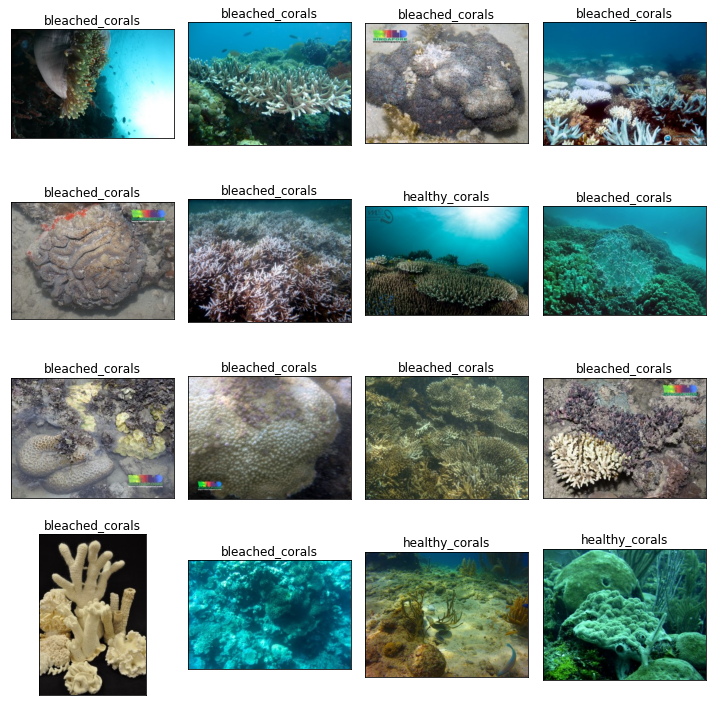

In [12]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [13]:
train_df, test_df = train_test_split(image_df, 
                                     test_size = 0.2, 
                                     shuffle = True, 
                                     random_state = 42)

In [14]:
train_df.shape

(1476, 2)

In [15]:
test_df.shape

(369, 2)

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
train_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input, 
    validation_split = 0.2
)
test_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input
)

In [18]:
train_generator

In [19]:
test_generator

In [20]:
train_image = train_generator.flow_from_dataframe(
    dataframe = train_df, 
    x_col = 'Filepath',
    y_col = 'Label',
    traget_size = image_size, 
    batch_size = batch_size, 
    shuffle = True, 
    color_mode = 'rgb', 
    class_mode = 'categorical', 
    subset = 'training', 
    random_seed = 42
)

Found 1181 validated image filenames belonging to 2 classes.


In [21]:
valid_image = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = image_size,
    batch_size = batch_size,
    shuffle = True,
    random_seed = 42,
    subset = 'validation',
    color_mode = 'rgb',
    class_mode = 'categorical'
)

Found 295 validated image filenames belonging to 2 classes.


In [22]:
test_image = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True,
    random_seed = 42
)

Found 369 validated image filenames belonging to 2 classes.


In [23]:
augment = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224, 224),
    layers.experimental.preprocessing.Rescaling(1/225),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1)
])

In [25]:
pretrained_model = tf.keras.applications.vgg19.VGG19(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'max'
)
pretrained_model.trainable = False

In [26]:
checkpoint_path = "coral_classification_model_checkpoint"
checkpoint_callbacks = ModelCheckpoint(checkpoint_path, 
                                       save_weights_only = True, 
                                       monitor = 'val_accurcay',
                                       save_best_only = True)

In [27]:
early_stopping = EarlyStopping(monitor = 'val_loss', 
                               patience = 5, 
                               restore_best_weights = True)

In [28]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3, 
                              mi_le = 1e-10)

In [29]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)

In [30]:
outputs = Dense(2, activation = 'softmax')(x)

In [31]:
model = Model(inputs = inputs, outputs = outputs)

In [32]:
model.compile(optimizer = Adam(0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [36]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

def create_tensorboard_callback(log_dir, experiment_name):
    log_dir = log_dir + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [38]:
history = model.fit(
    train_image,
    steps_per_epoch=len(train_image),
    validation_data=valid_image,
    validation_steps=len(valid_image),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "corals_classification"),
        checkpoint_callbacks,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/corals_classification/20230527-125721
Epoch 1/100
37/37 [==============================] - 1452s 38s/step - loss: 0.8549 - accuracy: 0.6478 - val_loss: 1.4217 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/100
37/37 [==============================] - 1372s 37s/step - loss: 0.5853 - accuracy: 0.7604 - val_loss: 0.8806 - val_accuracy: 0.6746 - lr: 0.0010
Epoch 3/100
37/37 [==============================] - 1676s 46s/step - loss: 0.5041 - accuracy: 0.7883 - val_loss: 0.5538 - val_accuracy: 0.7966 - lr: 0.0010
Epoch 4/100
37/37 [==============================] - 1132s 30s/step - loss: 0.4565 - accuracy: 0.8019 - val_loss: 0.5880 - val_accuracy: 0.7797 - lr: 0.0010
Epoch 5/100
37/37 [==============================] - 1108s 30s/step - loss: 0.4040 - accuracy: 0.8323 - val_loss: 0.4969 - val_accuracy: 0.7864 - lr: 0.0010
Epoch 6/100
37/37 [==============================] - 1102s 30s/step - loss: 0.3739 - accuracy: 0.8552 - val_loss: 0.4469 - val_acc

In [39]:
model.save('model_VGG19.h5')

In [40]:
results = model.evaluate(test_image, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.46690
Test Accuracy: 85.91%


In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

<Figure size 432x288 with 0 Axes>

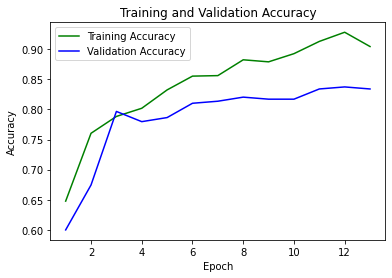

<Figure size 432x288 with 0 Axes>

In [42]:
#accuracy
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

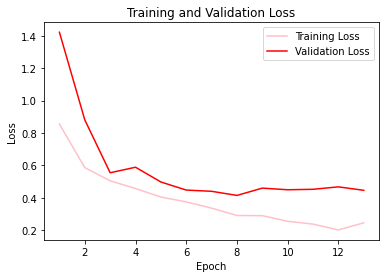

In [43]:
# Loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

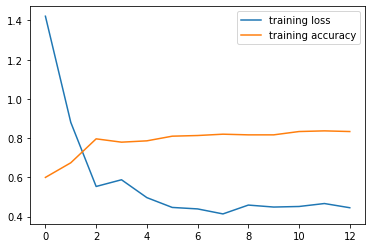

In [44]:
plt.plot(history.history['val_loss'], label = 'training loss')
plt.plot(history.history['val_accuracy'], label = 'training accuracy')
plt.legend()

In [45]:
pred = model.predict(test_image)
pred = np.argmax(pred,axis=1)

12/12 [==============================] - 236s 19s/step


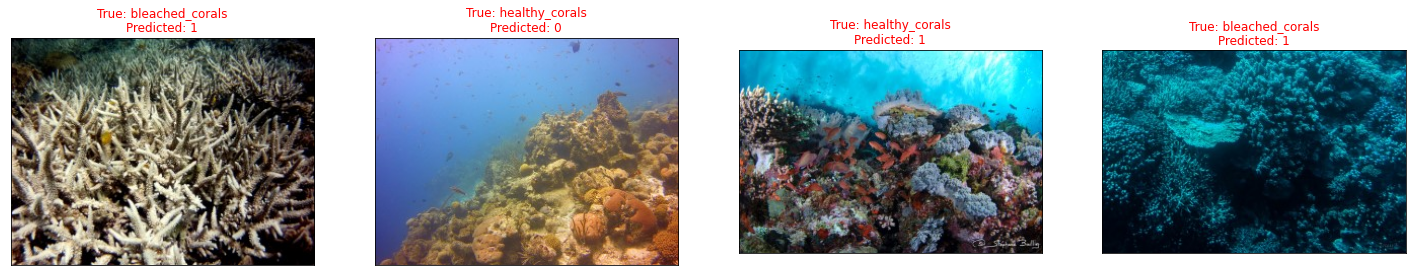

<Figure size 432x288 with 0 Axes>

In [52]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()